In [ ]:
!pip install d2l==0.17.1

In [ ]:
import warnings
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [ ]:
d2l.DATA_HUB['pokemon'] = (d2l.DATA_URL + 'pokemon.zip',
                           'c065c0e2593b8b161a2d7873e42418bf6a21106c')

data_dir = d2l.download_extract('pokemon')
pokemon = torchvision.datasets.ImageFolder(data_dir)

In [ ]:
batch_size = 256
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((64, 64)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5)
])
pokemon.transform = transformer
data_iter = torch.utils.data.DataLoader(
    pokemon, batch_size=batch_size,
    shuffle=True, num_workers=d2l.get_dataloader_workers())

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


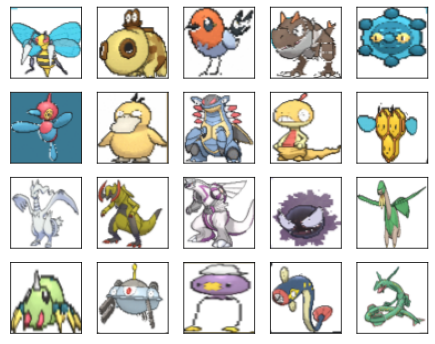

In [ ]:
warnings.filterwarnings('ignore')
d2l.set_figsize((4, 4))
for X, y in data_iter:
    imgs = X[0:20,:,:,:].permute(0, 2, 3, 1)/2+0.5
    d2l.show_images(imgs, num_rows=4, num_cols=5)
    break


In [ ]:
import torch 
import numpy as np 


class CPLX:
    
    def __init__(self, real, imag):
        self.r = real
        self.i = imag 
    
    def magnitude(self):
        return torch.sqrt(self.r.pow(2) + self.i.pow(2))
    
    def size(self):
        return self.r.size(), self.i.size()

    def flatten(self):
        self.r = torch.flatten(self.r)
        self.i = torch.flatten(self.i)
    
    def to_complex(self):
        x = self.r.data.numpy() + self.i.data.numpy() * 1j
        return x

In [ ]:
import torch
import torch.nn as nn 
import numpy as np 






class zReLU(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        rmask = torch.ge(x.r, torch.zeors_like(x.r)).float()
        imask = torch.ge(x.i, torch.zeors_like(x.i)).float()
        mask = rmask * imask
        out = CPLX(x.r * mask, x.i * mask)
        return out

class CReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.rRelu = nn.ReLU()
        self.iRelu = nn.ReLU()

    def forward(self, x):
        return CPLX(self.rRelu(x.r), self.iRelu(x.i))

In [ ]:
import torch
import torch.nn as nn
import numpy as np 







class ComplexConv2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1,
                 groups=1, bias=True, padding_mode='zeros'):
        super().__init__()

        self.rConv2d = nn.Conv2d(in_channels, out_channels, kernel_size, 
                                stride=stride, padding=padding, 
                                dilation=dilation, groups=groups, 
                                bias=bias)

        self.iConv2d = nn.Conv2d(in_channels, out_channels, kernel_size, 
                                stride=stride, padding=padding, 
                                dilation=dilation, groups=groups, 
                                bias=bias)
    
    def forward(self, x):
        r = self.rConv2d(x.r) - self.iConv2d(x.i)
        i = self.rConv2d(x.i) + self.iConv2d(x.r)

        out = CPLX(r, i)

        return out


class ComplexConvTranspose2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size,
                 stride=1, padding=0, dilation=1,
                 groups=1, bias=True, padding_mode='zeros'):
        super().__init__()

        self.rConvTranspose2d = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 
                                stride=stride, padding=padding, 
                                dilation=dilation, groups=groups, 
                                bias=bias)

        self.iConvTranspose2d = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, 
                                stride=stride, padding=padding, 
                                dilation=dilation, groups=groups, 
                                bias=bias)

    def forward(self, x):
        r = self.rConvTranspose2d(x.r) - self.iConvTranspose2d(x.i)
        i = self.rConvTranspose2d(x.i) + self.iConvTranspose2d(x.r)

        out = CPLX(r, i)

        return out


class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True  ):
        super().__init__()

        self.rLinear = nn.Linear(in_features, out_features, bias=bias)

        self.iLinear = nn.Linear(in_features, out_features, bias=bias)
    
    def forward(self, x):
        r = self.rLinear(x.r) - self.iLinear(x.i)
        i = self.rLinear(x.i) + self.iLinear(x.r)

        out = CPLX(r, i)

        return out

class ComplexAvgPool2d(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0, 
                ceil_mode=False, count_include_pad=True):

        self.rAvg = nn.AvgPool2d(kernel_size, stride=stride, padding=padding, 
                                ceil_mode=ceil_mode, count_include_pad=count_include_pad )
        
        self.iAvg = nn.AvgPool2d(kernel_size, stride=stride, padding=padding, 
                                ceil_mode=ceil_mode, count_include_pad=count_include_pad)

    def forward(self, x):
        return CPLX(self.rAvg(x.r), self.iAvg(x.i))

In [ ]:
import torch 





def concat(axis=-1, *args):

    x_r = torch.cat([j.r for j in args], axis=axis)
    x_i = torch.cat([j.i for j in args], axis=axis)

    return CPLX(x_r, x_i)

def loss(labels, predictions, loss_function, use_magnitude=True):
    if isinstance(labels, CPLX):
        return  loss_function(labels.r, predictions.r) + loss_function(labels.i, predictions.i)
    elif use_magnitude:
        return loss_function(labels, predictions.magnitude())

#Real-Valued GAN

In [ ]:
class G_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                 padding=1, **kwargs):
        super(G_block, self).__init__(**kwargs)
        self.conv2d_trans = nn.ConvTranspose2d(in_channels, out_channels,
                                kernel_size, strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d_trans(X)))

In [ ]:
x = torch.zeros((2, 3, 16, 16))
g_blk = G_block(20)
g_blk(x).shape

torch.Size([2, 20, 32, 32])

In [ ]:
x = torch.zeros((2, 3, 1, 1))
g_blk = G_block(20, strides=1, padding=0)
g_blk(x).shape

torch.Size([2, 20, 4, 4])

In [ ]:
n_G = 64
net_G = nn.Sequential(
    G_block(in_channels=100, out_channels=n_G*8,
            strides=1, padding=0),                  # Output: (64 * 8, 4, 4)
    G_block(in_channels=n_G*8, out_channels=n_G*4), # Output: (64 * 4, 8, 8)
    G_block(in_channels=n_G*4, out_channels=n_G*2), # Output: (64 * 2, 16, 16)
    G_block(in_channels=n_G*2, out_channels=n_G),   # Output: (64, 32, 32)
    nn.ConvTranspose2d(in_channels=n_G, out_channels=3,
                       kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh())  # Output: (3, 64, 64)

In [ ]:
x = torch.zeros((1, 100, 1, 1))
net_G(x).shape

torch.Size([1, 3, 64, 64])

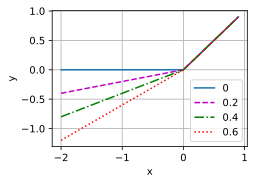

In [ ]:
alphas = [0, .2, .4, .6, .8, 1]
x = torch.arange(-2, 1, 0.1)
Y = [nn.LeakyReLU(alpha)(x).detach().numpy() for alpha in alphas]
d2l.plot(x.detach().numpy(), Y, 'x', 'y', alphas)

In [ ]:
class D_block(nn.Module):
    def __init__(self, out_channels, in_channels=3, kernel_size=4, strides=2,
                padding=1, alpha=0.2, **kwargs):
        super(D_block, self).__init__(**kwargs)
        self.conv2d = nn.Conv2d(in_channels, out_channels, kernel_size,
                                strides, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(alpha, inplace=True)

    def forward(self, X):
        return self.activation(self.batch_norm(self.conv2d(X)))

In [ ]:
x = torch.zeros((2, 3, 16, 16))
d_blk = D_block(20)
d_blk(x).shape

torch.Size([2, 20, 8, 8])

In [ ]:
n_D = 64
net_D = nn.Sequential(
    D_block(n_D),  # Output: (64, 32, 32)
    D_block(in_channels=n_D, out_channels=n_D*2),  # Output: (64 * 2, 16, 16)
    D_block(in_channels=n_D*2, out_channels=n_D*4),  # Output: (64 * 4, 8, 8)
    D_block(in_channels=n_D*4, out_channels=n_D*8),  # Output: (64 * 8, 4, 4)
    nn.Conv2d(in_channels=n_D*8, out_channels=1,
              kernel_size=4, bias=False))  # Output: (1, 1, 1)

In [ ]:
x = torch.zeros((1, 3, 64, 64))
net_D(x).shape

torch.Size([1, 1, 1, 1])

In [ ]:
def train(net_D, net_G, data_iter, num_epochs, lr, latent_dim,
          device=d2l.try_gpu()):
    loss = nn.BCEWithLogitsLoss(reduction='sum')
    for w in net_D.parameters():
        nn.init.normal_(w, 0, 0.02)
    for w in net_G.parameters():
        nn.init.normal_(w, 0, 0.02)
    net_D, net_G = net_D.to(device), net_G.to(device)
    trainer_hp = {'lr': lr, 'betas': [0.5,0.999]}
    trainer_D = torch.optim.Adam(net_D.parameters(), **trainer_hp)
    trainer_G = torch.optim.Adam(net_G.parameters(), **trainer_hp)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[1, num_epochs], nrows=2, figsize=(5, 5),
                            legend=['discriminator', 'generator'])
    animator.fig.subplots_adjust(hspace=0.3)
    for epoch in range(1, num_epochs + 1):
        # Train one epoch
        timer = d2l.Timer()
        metric = d2l.Accumulator(3)  # loss_D, loss_G, num_examples
        for X, _ in data_iter:
            batch_size = X.shape[0]
            Z = torch.normal(0, 1, size=(batch_size, latent_dim, 1, 1))
            X, Z = X.to(device), Z.to(device)
            metric.add(d2l.update_D(X, Z, net_D, net_G, loss, trainer_D),
                       d2l.update_G(Z, net_D, net_G, loss, trainer_G),
                       batch_size)
        # Show generated examples
        Z = torch.normal(0, 1, size=(21, latent_dim, 1, 1), device=device)
        # Normalize the synthetic data to N(0, 1)
        fake_x = net_G(Z).permute(0, 2, 3, 1) / 2 + 0.5
        imgs = torch.cat(
            [torch.cat([
                fake_x[i * 7 + j].cpu().detach() for j in range(7)], dim=1)
             for i in range(len(fake_x)//7)], dim=0)
        animator.axes[1].cla()
        animator.axes[1].imshow(imgs)
        # Show the losses
        loss_D, loss_G = metric[0] / metric[2], metric[1] / metric[2]
        animator.add(epoch, (loss_D, loss_G))
    print(f'loss_D {loss_D:.3f}, loss_G {loss_G:.3f}, '
          f'{metric[2] / timer.stop():.1f} examples/sec on {str(device)}')

In [ ]:
latent_dim, lr, num_epochs = 100, 0.005, 20
train(net_D, net_G, data_iter, num_epochs, lr, latent_dim)